## Import Required Libraries
Import the necessary libraries, including os, PIL, and matplotlib.

In [5]:
%load_ext autoreload
%autoreload 2

import os
from PIL import Image
import matplotlib.pyplot as plt
import math
import json
import pandas as pd
import numpy as np
import torch
import sys
import csv
from tqdm import tqdm
import numpy as np

dataset_path = r'C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\Miccai 2022 BUV Dataset\rawframes'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experimenting with the data

### Helper Functions

In [6]:
def load_json(json_file_path):
    # open and load the JSON file
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def load_images(folder_path, num_images=None):
    image_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
                if (num_images) and (len(image_files) == num_images):
                    break
    return image_files

def display_images(image_files):
    for i, image_file in enumerate(image_files):
        img = Image.open(image_file)
        plt.figure(figsize=(3, 3))
        plt.imshow(img )
        plt.title(os.path.basename(image_file))
        plt.axis('off')
        plt.show()

def load_and_display_images(folder_path,  num_images=None):
    """
    Load and display images from the specified folder.

    :param folder_path: Path to the folder containing images.
    :param num_images: Number of images to display.
    """
    image_files = load_images(folder_path, num_images)
    display_images(image_files)


def load_and_display_images_with_bb(training_json_dict, video_id, num_images=None, save_folder=None, display_images=True):
    training_keys = list(training_json_dict.keys())
    dict_image_data = training_json_dict[training_keys[2]]
    dict_annotation_data = training_json_dict[training_keys[3]]

    images_df = pd.DataFrame(dict_image_data)
    images_df = images_df[images_df['video_id'] == video_id]

    annotation_df = pd.DataFrame(dict_annotation_data)

    images_list = list(images_df.file_name)
    if not num_images:
        num_images = len(images_list)

    image_arrays = []
    for i, image_name in tqdm(enumerate(images_list[:num_images])):
        image_id = int(images_df[images_df['file_name'] == image_name].id)
        bbox = list(annotation_df[annotation_df['image_id'] == image_id]['bbox'])[0]
        image_array = np.array(Image.open(os.path.join(dataset_path, image_name)))
        image_arrays.append(image_array)
        plt.figure(figsize=(10, 10))
        plt.imshow(image_array)
        plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], edgecolor='green', facecolor='none', linewidth=2))
        plt.axis('off')
        
        if save_folder:
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            plt.savefig(os.path.join(save_folder, os.path.basename(image_name)))
        
        if display_images:
            plt.show()

def buv_json_to_csv(buv_json_file, output_csv_file, two_points_format=True, only_train_frames=False):	
    json_dict = load_json(buv_json_file)
    dict_keys = list(json_dict.keys())
    dict_image_data = json_dict[dict_keys[2]]
    dict_annotation_data = json_dict[dict_keys[3]]

    images_df = pd.DataFrame(dict_image_data)
    if only_train_frames:
        images_df = images_df[images_df['is_vid_train_frame'] == True]

    annotation_df = pd.DataFrame(dict_annotation_data)


    images_list = list(images_df.file_name)
    print('image_list_size: ', len(images_list))

    images_to_ignore_list = ['benign/x66ef02e7f1b9a0ef', 'benign/x63c9ba1377f35bf6', 'benign/x5a1c46ec6377e946']

    with open(output_csv_file, 'w', newline='') as csvfile:
        fieldnames = ['img_file', 'x1', 'y1', 'x2', 'y2', 'class_name']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    
        for image_name in tqdm(images_list):

            ignore = False
            for image_to_ignore in images_to_ignore_list:
                if image_to_ignore in image_name:
                    ignore = True
            if ignore:
                print(f'Image {image_name} is ignored')
                continue

            image_id = int(images_df[images_df['file_name'] == image_name].id)
            bbox = list(annotation_df[annotation_df['image_id'] == image_id]['bbox'])[0]

            if two_points_format:
                writer.writerow({
                    'img_file': os.path.join(dataset_path, image_name),
                    'x1': bbox[0] if bbox[2]>=0 else bbox[0] + bbox[2],
                    'y1': bbox[1] if bbox[3]>=0 else bbox[1] + bbox[3],
                    'x2': bbox[0] + bbox[2] if bbox[2]>=0 else bbox[0],
                    'y2': bbox[1] + bbox[3] if bbox[3]>=0 else bbox[1],
                    'class_name': 'Lesion'
                })
            else:
                writer.writerow({
                            'img_file': os.path.join(dataset_path, image_name),
                            'x1': bbox[0],
                            'y1': bbox[1],
                            'x2': bbox[2],
                            'y2': bbox[3],
                            'class_name': 'Lesion'
                        })
   


### Displaying the data

In [7]:
training_json_file = r'C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\Miccai 2022 BUV Dataset\imagenet_vid_train_15frames.json'
training_csv_file = r'C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\Miccai 2022 BUV Dataset\train_annotations_2.csv'

#buv_json_to_csv(training_json_file, training_csv_file, only_train_frames=True)

validation_json_file = r'C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\Miccai 2022 BUV Dataset\imagenet_vid_val.json'
validation_csv_file = r'C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\Miccai 2022 BUV Dataset\val_annotations.csv'

#buv_json_to_csv(validation_json_file, validation_csv_file)

In [ ]:
training_json_dict = load_json(r'C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\Miccai 2022 BUV Dataset\imagenet_vid_train_15frames.json')
video_id = 63
save_path = r'C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\example_images\63'
load_and_display_images_with_bb(training_json_dict, video_id, save_folder=save_path, display_images=False)

folder_path = r'C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\Miccai 2022 BUV Dataset\rawframes\benign\2cda21c3aab26332'
#load_and_display_images(folder_path)

### Experimenting with the .json data files

In [8]:
import os
folder_path = r'C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\Miccai 2022 BUV Dataset\rawframes\benign'
video_name = os.listdir(folder_path)
file_name = os.listdir(os.path.join(folder_path,video_name[0]))

training_json_dict = load_json(r'C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\Miccai 2022 BUV Dataset\imagenet_vid_train_15frames.json')
training_keys = list(training_json_dict.keys())
print(training_keys)

video_index = 0

video_name = training_json_dict[training_keys[1]][video_index]['name']
video_folder_path = os.listdir(os.path.join(dataset_path,video_name))

# print the loaded data
print(list(training_json_dict.keys()))
print(training_json_dict[list(training_json_dict.keys())[0]][0])
print(training_json_dict[list(training_json_dict.keys())[1]][0])
print(training_json_dict[list(training_json_dict.keys())[2]][29])
print(training_json_dict[list(training_json_dict.keys())[3]][0])

['categories', 'videos', 'images', 'annotations']
['categories', 'videos', 'images', 'annotations']
{'id': 1, 'name': 'benign', 'encode_name': 'benign'}
{'id': 1, 'name': 'benign/x28f299ceb056964c', 'vid_train_frames': [-1, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139]}
{'file_name': 'benign/x28f299ceb056964c/000029.png', 'height': 670, 'width': 670, 'id': 30, 'frame_id': 29, 'video_id': 1, 'is_vid_train_frame': True}
{'id': 1, 'video_id': 1, 'image_id': 1, 'category_id': 1, 'instance_id': 1, 'bbox': [211, 127, 192, 146], 'area': 28032, 'iscrowd': False, 'occluded': False, 'generated': False}


## Retinanet visualisation and Evaluation on the data

In [9]:
sys.path.append('./pytorch-retinanet')
from torchvision import transforms
from retinanet import model
from retinanet.dataloader import CocoDataset, Resizer, Normalizer

model_path = r"C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\retinanet_checkpoints\coco_resnet_50_map_0_335_state_dict.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
retinanet = model.resnet50(num_classes=80)
retinanet.load_state_dict(torch.load(model_path, map_location=device))
retinanet = retinanet.to(device)

# Transform the image
transform = transforms.Compose([Normalizer(), Resizer()])
# Load the image as a PIL image
folder_path = r'C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\Miccai 2022 BUV Dataset\rawframes\benign\2cda21c3aab26332'
image_path = load_images(folder_path)[0]
print(image_path)
image_pil = Image.open(image_path).convert('RGB')

# Transform the image
sample = {'img': np.array(image_pil), 'annot': np.zeros((0, 5))}
transformed_sample = transform(sample)
transformed_image = transformed_sample['img'].permute(2, 0, 1).unsqueeze(0).to(device)

# Set the model to evaluation mode
retinanet.eval()

# Perform inference
with torch.no_grad():
    scores, classification, transformed_anchors = retinanet(transformed_image)

# Process the results
for idx in range(scores.shape[0]):
    if scores[idx] > 0.5:  # Threshold for detection
        bbox = transformed_anchors[idx, :]
        x1, y1, x2, y2 = bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()
        label = int(classification[idx])
        print(f"Detected object with score {scores[idx]:.2f} at [{x1}, {y1}, {x2}, {y2}] with label {label}")
        plt.figure(figsize=(6, 6))
        plt.imshow(image_pil)
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', facecolor='none', linewidth=2))
        plt.title(f'Detected object with score {scores[idx]:.2f}')
        plt.axis('off')
        plt.show()


RuntimeError: Error(s) in loading state_dict for ResNetWithTemporalAttention:
	Missing key(s) in state_dict: "temporal_attention_C3.attention.in_proj_weight", "temporal_attention_C3.attention.in_proj_bias", "temporal_attention_C3.attention.out_proj.weight", "temporal_attention_C3.attention.out_proj.bias", "temporal_attention_C4.attention.in_proj_weight", "temporal_attention_C4.attention.in_proj_bias", "temporal_attention_C4.attention.out_proj.weight", "temporal_attention_C4.attention.out_proj.bias", "temporal_attention_C5.attention.in_proj_weight", "temporal_attention_C5.attention.in_proj_bias", "temporal_attention_C5.attention.out_proj.weight", "temporal_attention_C5.attention.out_proj.bias", "feature_align_C3.weight", "feature_align_C4.weight", "feature_align_C5.weight". 
	size mismatch for fpn.P5_1.weight: copying a param with shape torch.Size([256, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for fpn.P4_1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for fpn.P3_1.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for fpn.P6.weight: copying a param with shape torch.Size([256, 2048, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).

In [25]:
models_directory = r"C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\pytorch-retinanet\trained_networks"
sys.path.append('./pytorch-retinanet')

import cv2
import time
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

#from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, UnNormalizer, Normalizer
from retinanet.dataloader_sequence import CocoDataset, collater, AspectRatioBasedSampler,Normalizer, Resizer
from retinanet import coco_eval

csv_val = r"C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\Miccai 2022 BUV Dataset\val_annotations.csv"
csv_classes = r"C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\Miccai 2022 BUV Dataset\class_name.csv"
dataset_val = CocoDataset('../Miccai 2022 BUV Dataset', set_name='imagenet_vid_val', sequence_length=3, transform=transforms.Compose([Normalizer(), Resizer()]), only_train_frames=False)
sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
dataloader_val = DataLoader(dataset_val, num_workers=1, collate_fn=collater, batch_sampler=sampler_val)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
def draw_caption(image, box, caption):
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)

def visualize_network_outputs(retinanet, dataloader_val, dataset_val, num_images=10, show_ground_truth=True):
    unnormalize = UnNormalizer()
    retinanet.eval()

    for idx, data in enumerate(dataloader_val):
        if idx >= num_images:
            break
        with torch.no_grad():
            st = time.time()
            if torch.cuda.is_available():
                scores, classification, transformed_anchors = retinanet(data['img'].cuda().float())
            else:
                scores, classification, transformed_anchors = retinanet(data['img'].float())
            print('Elapsed time: {}'.format(time.time() - st))
            idxs = np.where(scores.cpu() > 0.5)
            img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()

            img[img < 0] = 0
            img[img > 255] = 255
            img = np.transpose(img, (1, 2, 0))
            img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)

            for j in range(idxs[0].shape[0]):
                bbox = transformed_anchors[idxs[0][j], :]
                x1 = int(bbox[0])
                y1 = int(bbox[1])
                x2 = int(bbox[2])
                y2 = int(bbox[3])
                label_name = dataset_val.labels[int(classification[idxs[0][j]])]
                #draw_caption(img, (x1, y1, x2, y2), label_name)
                cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
                print(label_name)

            if show_ground_truth:
                annotations = data['annot'][0]
                for k in range(annotations.shape[0]):
                    bbox = annotations[k, :4]
                    x1 = int(bbox[0])
                    y1 = int(bbox[1])
                    x2 = int(bbox[2])
                    y2 = int(bbox[3])
                    cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            # Evaluate the image and print metrics
            annotations = dataset_val.load_annotations(idx)
            detections = np.concatenate([transformed_anchors[idxs[0], :].cpu().numpy(), scores[idxs[0]].cpu().numpy().reshape(-1, 1)], axis=1)
            average_precisions = csv_eval.process_image(dataset_val[idx], retinanet, score_threshold=0.05, max_detections=1,)
            print(f"Image {idx + 1} Evaluation Metrics:")
            print(average_precisions[average_precisions[:, -1] == 0, :-1])

model = os.path.join(models_directory, 'experiment_1\csv_retinanet_19.pt')
retinanet = torch.load(model)
#visualize_network_outputs(retinanet, dataloader_val, dataset_val, num_images=10)


In [26]:
experiment_6_directory = os.path.join(models_directory, 'experiment_6')



def validate_and_save(experiment_directory, coco_metrics=True, plot_froc=True, validation_json_file=None):
    for model_name in os.listdir(experiment_directory):

        if not model_name.endswith('.pt'):
            continue

        print(model_name)
        if coco_metrics:
            output_json_file = os.path.join(experiment_directory, f'{model_name}_coco_metrics.json')
        else:
            raise ValueError('Only COCO metrics are supported at the moment')
        
        model_path = os.path.join(experiment_directory, model_name)
        retinanet = torch.load(model_path)
        if coco_metrics:
            if not validation_json_file:
                raise ValueError('validation_json_file must be provided when using COCO metrics')
            metrics_list = coco_eval.evaluate_coco_sequence(dataset_val, retinanet, model_path=model_path),
        else:
            raise ValueError('Only COCO metrics are supported at the moment')
        
        if not os.path.exists(output_json_file):
            with open(output_json_file, 'w') as f:
                json.dump(metrics_list, f, indent=4)

        if plot_froc:
            thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
            #csv_eval.evaluate_froc(dataset_val, retinanet, buv_json_file=validation_json_file, model_path=model_path, score_thresholds=thresholds)

In [27]:
validation_json_file = r'C:\Users\zaid-\OneDrive\Desktop\PMSD\Implementation\Miccai 2022 BUV Dataset\imagenet_vid_val.json'

In [42]:
validate_and_save(experiment_6_directory, validation_json_file=validation_json_file)

coco_retinanet_0.pt
torch.Size([1, 69354, 4])


RuntimeError: The size of tensor a (4) must match the size of tensor b (69354) at non-singleton dimension 2

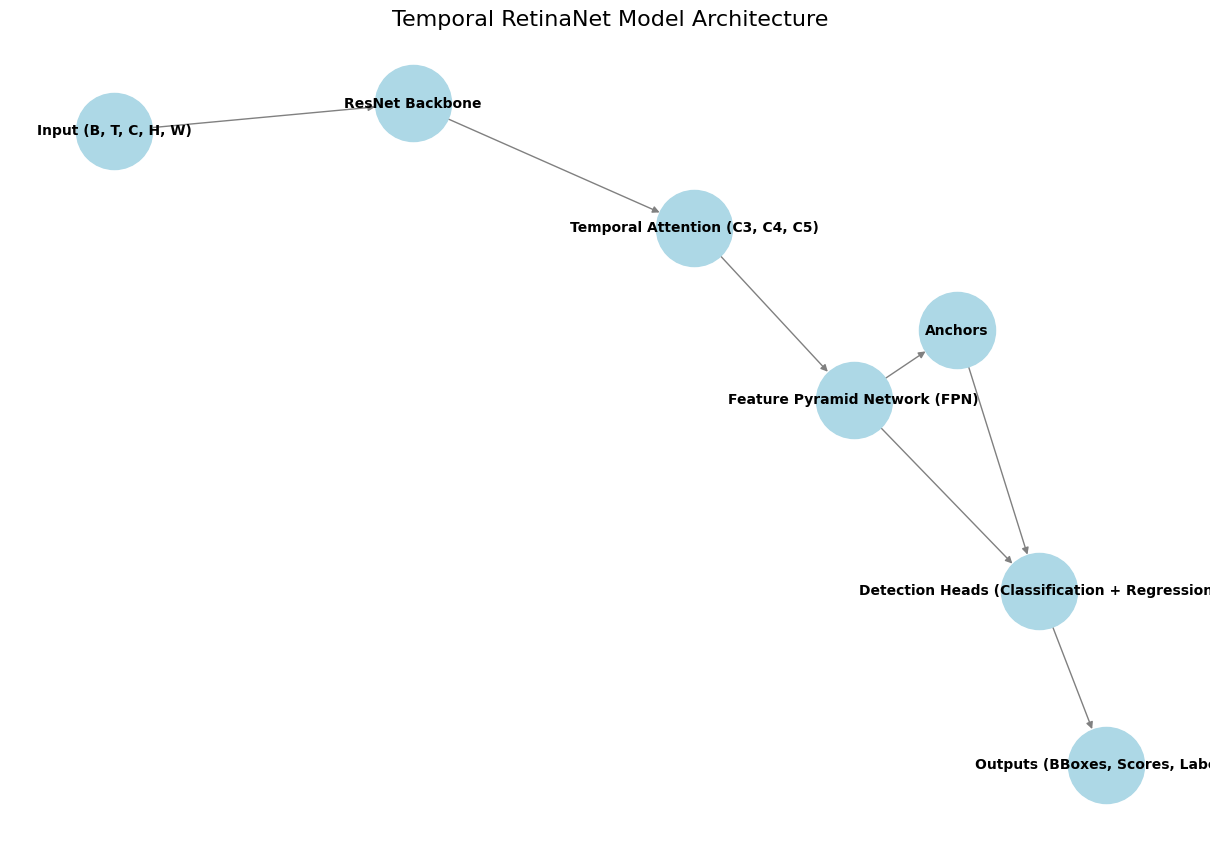

In [43]:
import matplotlib.pyplot as plt
import networkx as nx

# Initialize directed graph
G = nx.DiGraph()

# Nodes for model architecture
nodes = [
    "Input (B, T, C, H, W)", 
    "ResNet Backbone", 
    "Temporal Attention (C3, C4, C5)", 
    "Feature Pyramid Network (FPN)", 
    "Detection Heads (Classification + Regression)", 
    "Anchors", 
    "Outputs (BBoxes, Scores, Labels)"
]

# Add edges for model flow
edges = [
    ("Input (B, T, C, H, W)", "ResNet Backbone"),
    ("ResNet Backbone", "Temporal Attention (C3, C4, C5)"),
    ("Temporal Attention (C3, C4, C5)", "Feature Pyramid Network (FPN)"),
    ("Feature Pyramid Network (FPN)", "Detection Heads (Classification + Regression)"),
    ("Detection Heads (Classification + Regression)", "Outputs (BBoxes, Scores, Labels)"),
    ("Feature Pyramid Network (FPN)", "Anchors"),
    ("Anchors", "Detection Heads (Classification + Regression)")
]

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Generate layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray")
plt.title("Temporal RetinaNet Model Architecture", fontsize=16)
plt.show()
